# Assessment: Weekly deliverable template - Final project
<font color='#AC135A'>**Applied Machine Learning** - **Sheffield Hallam University**</font>


---

## Introduction
Add your solutions to the different sub-tasks requested for this deliverable.

<font color='red'>DO NOT ADD MORE CELLS TO THE FINAL VERSION OF THIS NOTEBOOK.

### 1. Dataset loading

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   

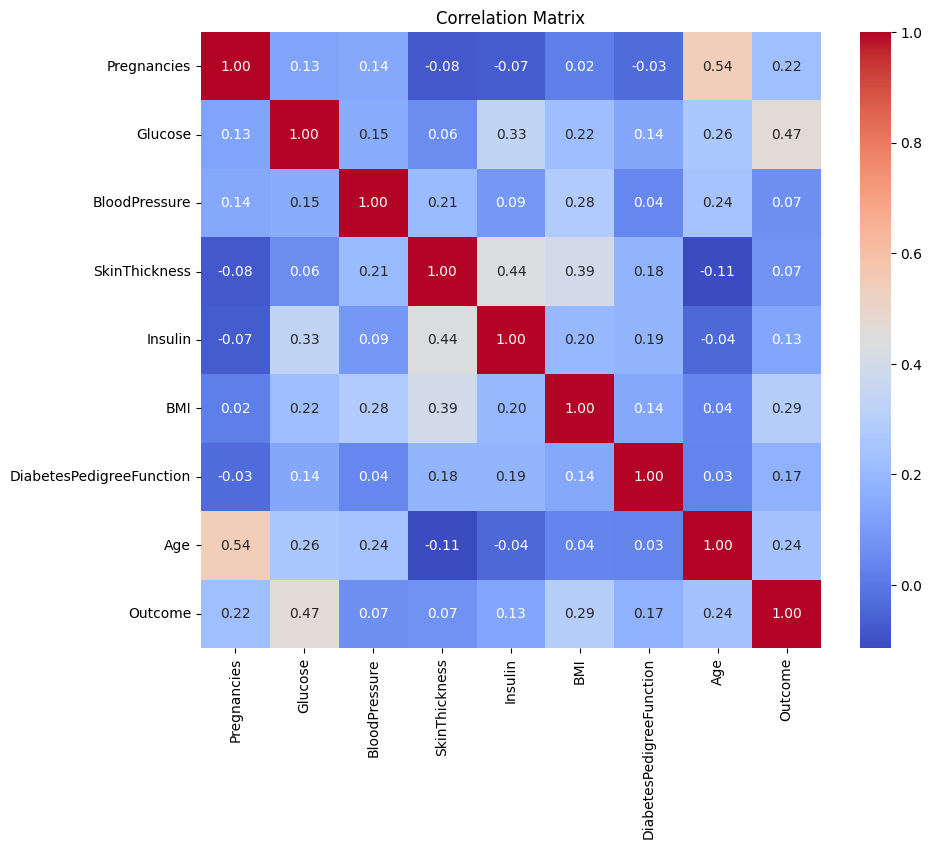

In [161]:
import pandas as pd

df = pd.read_csv('Pima Indians Diabetes Database.csv')

# Display the first few rows of the dataframe
print(df.head())
print(df.describe())

# show all examples with any missing values
print("\nShow counts of missing values in each column:")
print(df.isnull().sum())

import seaborn as sns  
import matplotlib.pyplot as plt 
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Observations:**  

All data are numeric. 

*Outcome* is our binary categorical target variable. In order to find a good predictor, I check for the best correlations in the correlation matrix.

By far the best correlation is by *Glucose* with 0.47. So ideally I would predict the diabetes risk based on that variable. However, Glucose is not suitable for the workplace as it requires some medical testing.

The next best variable is *BMI* with a 0.29 correlation to *Outcome*. This is a suitable variable as it is neither invasive, nor is it unfair. It is just an observation. So I will include BMI in my feature set. The interquartile range (IQR) for *BMI* is 9.3 (36.6–27.3), so the cut offs for outliers are 27.3–1.5\*9.3=13.35 (notably there are examples with a BMI of 0, which points to missing data), and 36.6+1.5\*9.3=50.55, respectively. 

Also *Age* has some degree of correlation at 0.24. It is also fair and not invasive. It also has a very low correlation with *BMI*, which means this variable may provide some valuable information. I will include *Age* in the feature set. The interquartile range (IQR) for *Age* is 17 (41–24), so the cut offs for outliers are 24–1.5\*17 (below 0, hence no outliers on the lower end), and 41+1.5\*17=66.5. So all ages above 66 can be considered outliers for the purpose of this dataset. Depending on the age structure of the workplace where the model will be deployed, this may be something to keep in mind. I will remove the examples with *Age* > 66 for this assessment.

*Pregnancies* has a similar correlation with *Outcome* as *Age*. However, *Pregancies* only applies to females, and it may be a sensitive question to ask in the workplace, hence I will not make use of this variable. There is also a relatively high correlation with *Age* at 0.54 which may indicate that the informational content of *Pregancies* is in part included in the *Age* variable. 

All other variables except for *BloodPressure* require medical testing or are complex, so not suitable for the workplace. For *BloodPressure*, the correlation with *Outcome* is very low however at 0.07, while there are much higher correlations with *Age* and *BMI*, so I decide to not use Glucose as a feature. This also helps to keep the model simple. 

### 2. Feature distributions + missing/outlier treatment




Count of examples with BMI of 0:
11

Dataframe description after cleaning:
              BMI         Age     Outcome
count  757.000000  757.000000  757.000000
mean    32.457464   33.281374    0.351387
std      6.924988   11.697752    0.477719
min     18.200000   21.000000    0.000000
25%     27.500000   24.000000    0.000000
50%     32.300000   29.000000    0.000000
75%     36.600000   41.000000    1.000000
max     67.100000   81.000000    1.000000

Outlier thresholds:
Lower bound:
BMI    13.85
Age    -1.50
dtype: float64
Upper bound:
BMI    50.25
Age    66.50
dtype: float64


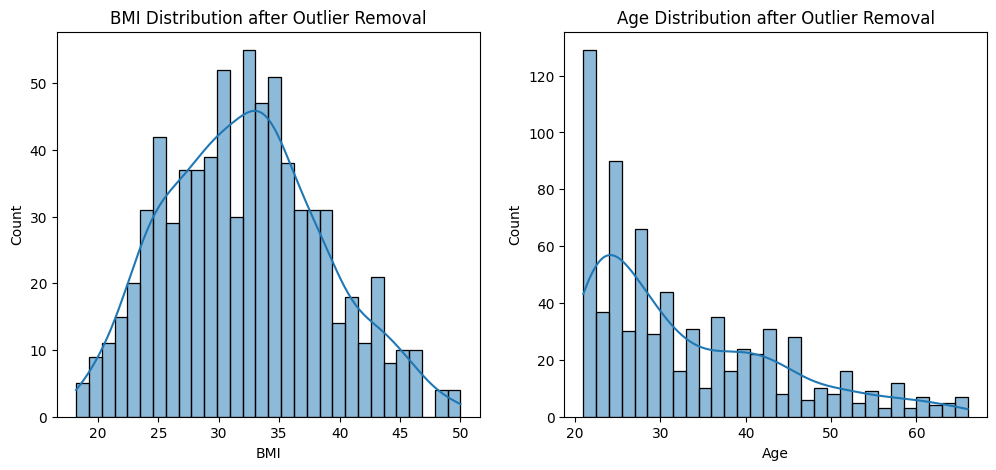

In [162]:
# Remove all columns from df except for 'BMI', 'Age' and 'Outcome'
df = df[['BMI', 'Age', 'Outcome']]

# Show how many examples have a BMI of 0
print("\nCount of examples with BMI of 0:")
print((df['BMI'] == 0).sum())

# Drop rows with BMI of 0
df = df[df['BMI'] != 0]
# Describe the dataframe again
print("\nDataframe description after cleaning:")
print(df.describe())

# For 'BMI' and 'Age', calculate the outlier thresholds using the IQR method
Q1 = df[['BMI', 'Age']].quantile(0.25)
Q3 = df[['BMI', 'Age']].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("\nOutlier thresholds:")
print("Lower bound:")
print(lower_bound)
print("Upper bound:")
print(upper_bound)

# Remove outliers
df = df[~((df[['BMI', 'Age']] < lower_bound) | (df[['BMI', 'Age']] > upper_bound)).any(axis=1)]

# Plot histograms of 'BMI' and 'Age' after removing outliers
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['BMI'], bins=30, kde=True)
plt.title('BMI Distribution after Outlier Removal')
plt.subplot(1, 2, 2)
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution after Outlier Removal')
plt.show()

**Observations:**  

The *BMI* values are well distributed. *Age* is right skewed. This may be a problem if we see that the higher ages have higher residuals, in which case we may need to balance the dataset to ensure equal weights (cf. Raschka et al. (2022). Machine Learning with Python and Scikit-Learn. Packt Publishing. p. 201ff.) 

### 3. Correlation heat-map and redundant features noted


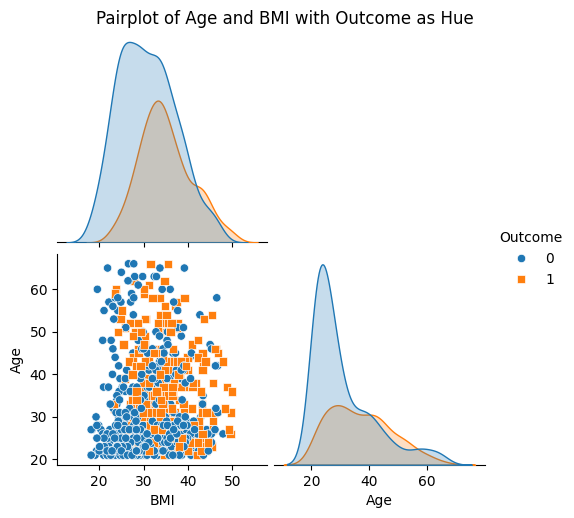

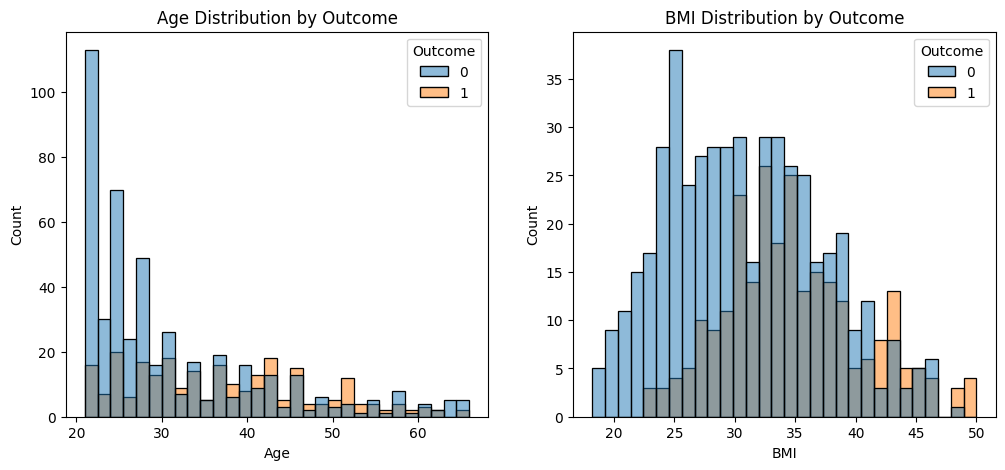

In [163]:
# Show a pairplot with density curves for 'Age' and 'BMI' with Outcome as hue
sns.pairplot(df, hue='Outcome', diag_kind='kde', markers=["o", "s"], corner=True)
plt.suptitle('Pairplot of Age and BMI with Outcome as Hue', y=1.02)
plt.show()  

# Showing a histogram of the 'Age' and 'BMI column with Outcome as hue
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Age', hue='Outcome', bins=30, kde=False)
plt.title('Age Distribution by Outcome')
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='BMI', hue='Outcome', bins=30, kde=False)
plt.title('BMI Distribution by Outcome')
plt.show()




**Observations:**  

Having already shown the correlation matrix and discussed features in 1., I thought I'd show how the selected features relate to *Outcome*. 

The KDE lines in the pairplot show that there is poor class separation. While the location of *Outcome* for both *Age* and *BMI* is shifted slightly towards higher values (hence the observed correlations), the diabetes peaks are "included" in the non-diabetes peaks. 

This is also reflected in the histogram plots. They show that the relationship betwen *Outcome* and *Age* and *BMI* respectively is of a similar kind. It shows more the *absence* of diabetes in people with low BMI, and the relativey low chance of diabetes in people of a young age. The opposite is not true: a high BMI does not necessarily mean the presence of diabetes, and also older age does not mean a high risk of diabetes. 

For our model this may mean that it will be difficult to predict diabetes with any certainty. It will be much easier to predict the absence of diabetes with a good accuracy. In other words, any good recall on diabetes (which we have to aim for) will come with relatively poor precision. 

### 4. ≥ 3 models trained and compared (Precision, Recall, AUC)


Best models after hyperparameter tuning:
logreg: LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear')
svm: SVC(C=1, class_weight='balanced', probability=True)
rf: RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=5, n_estimators=200)

Precision-Recall vs. Threshold for logreg:


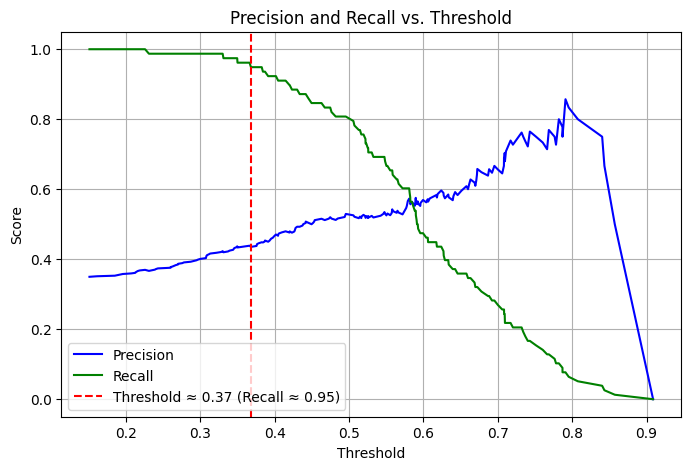


Precision-Recall vs. Threshold for svm:


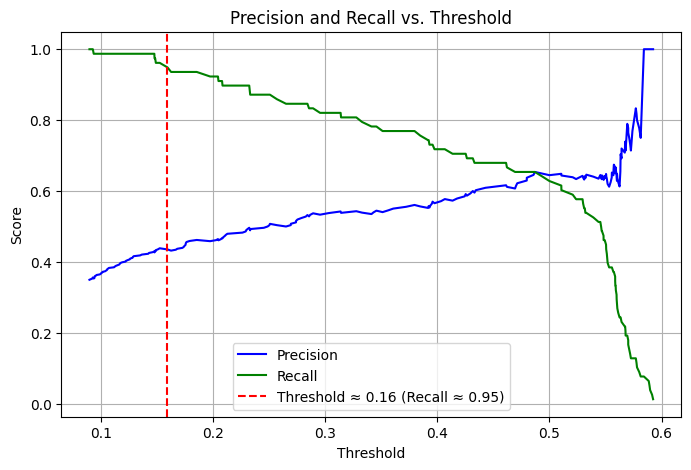


Precision-Recall vs. Threshold for rf:


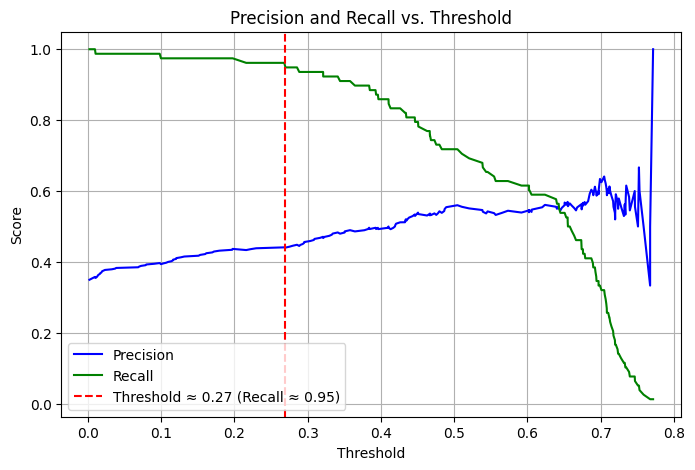


Model Evaluation Results at Target Recall:
    Model  Threshold  Precision  Recall  AUC-ROC
0  logreg   0.367935      0.435   0.949    0.757
1     svm   0.159570      0.435   0.949    0.785
2      rf   0.269823      0.440   0.949    0.751


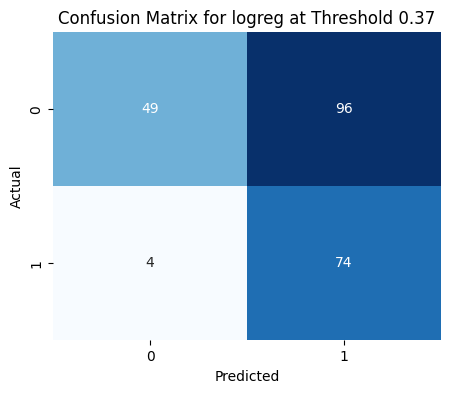

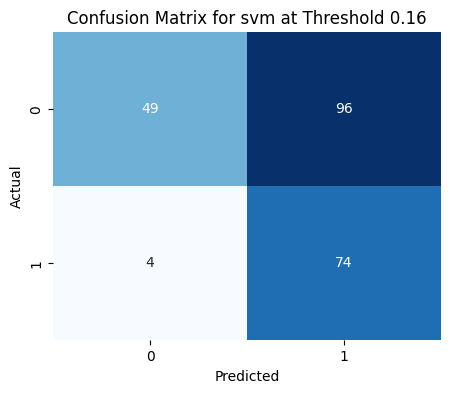

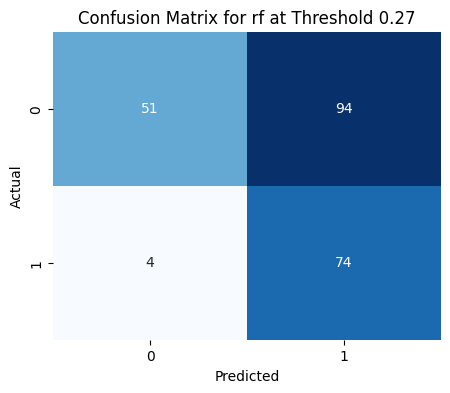

In [170]:
# Looking at the dataset, and the fact that we have a binary classification problem and only two features, I will use a logistic regression model.
# I will also anayse a random forest classifier for comparison. I feel a single decision tree may not give enough flexibility to increase recall. 
# Finally, I will also test SVM.

# The aim for this model must be to have a high recall, i.e. to identify as many diabetes cases as possible. I will use F2-score as the scoring metric, 
# which weights recall higher than precision.
# The best model will be the one with the highest precision at the best recall. 

# So I will test several parameters and models, and then plot precision-recall curves to find the best model.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split your dataset
X_train, X_test, y_train, y_test = train_test_split(df.drop('Outcome', axis=1), df['Outcome'], stratify=df['Outcome'], test_size=0.3, random_state=1)

# Scale for LR and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Define parameter grids for each model
param_grids = {
    'logreg': {
        'model': LogisticRegression(solver='liblinear'),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'class_weight': [None, 'balanced']
        }
    },
    'svm': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto'],
            'class_weight': [None, 'balanced']
        }
    },
    'rf': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5],
            'class_weight': [None, 'balanced']
        }
    }
}


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

# Choose scoring metric
fbeta = make_scorer(fbeta_score, beta=2)  # F2 favors recall more

best_models = {}

# Perform grid search for each model
for name, config in param_grids.items(): 
    # Choose scaled or unscaled input
    X_train_input = X_train_scaled if name in ['logreg', 'svm'] else X_train

    grid = GridSearchCV(config['model'], config['params'], scoring=fbeta, cv=5, n_jobs=-1)
    grid.fit(X_train_input, y_train)

    best_models[name] = grid.best_estimator_

models = {
    'logreg': best_models['logreg'],
    'svm': best_models['svm'],
    'rf': best_models['rf']
}
print("Best models after hyperparameter tuning:")
for name, model in models.items():
    print(f"{name}: {model}")

# As the goal is to have a high recall with the best possible precision, 
# I will plot recall vs. threshold plots to determine the best threshold for each model.
# Plot a graph that shows the threshold on the x axis and the recall and precision on the y axis
import numpy as np
from sklearn.metrics import precision_recall_curve
def plot_precision_recall_vs_threshold(y, y_probs):
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precision[:-1], label='Precision', color='b')
    plt.plot(thresholds, recall[:-1], label='Recall', color='g')
    # Find threshold for recall of 0.95 and draw a line there
    target_recall = 0.95
    idx = np.argmin(np.abs(recall - target_recall))
    threshold_at_target_recall = thresholds[idx]
    plt.axvline(x=threshold_at_target_recall, color='r', linestyle='--',
            label=f'Threshold ≈ {threshold_at_target_recall:.2f} (Recall ≈ {recall[idx]:.2f})')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs. Threshold')
    plt.legend()
    plt.grid()
    plt.show()
    return threshold_at_target_recall

threshold_at_target_recall = {}

for model in models:
    print(f"\nPrecision-Recall vs. Threshold for {model}:")
    X_eval = X_test if model == 'rf' else X_test_scaled
    y_probs = models[model].predict_proba(X_eval)[:, 1]
    threshold_at_target_recall[model] = plot_precision_recall_vs_threshold(y_test, y_probs)


# Evaluate each model at the threshold that gives a recall of 0.95
results = []
from sklearn.metrics import precision_score, recall_score, roc_auc_score

for name, model in models.items():
    # Choose scaled or unscaled input depending on model type
    X_eval = X_test if (name == 'rf') else X_test_scaled
    
    # Predict probabilities and evaluate at the chosen threshold (where recall =0.95)
    y_proba = model.predict_proba(X_eval)[:, 1]
    y_pred = (y_proba >= threshold_at_target_recall[name]).astype(int)

    # Compute metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred) # should be close to 0.95
    auc = roc_auc_score(y_test, y_proba)

    results.append({
        'Model': name,
        'Threshold': threshold_at_target_recall[name],
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'AUC-ROC': round(auc, 3)
    })
print("\nModel Evaluation Results at Target Recall:")
results_df = pd.DataFrame(results)
print(results_df)

# Now print confusion matrices for each model at the chosen threshold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
for name, model in models.items():
    # Choose scaled or unscaled input depending on model type
    X_eval = X_test if (name == 'rf') else X_test_scaled
    
    # Predict probabilities and evaluate at the chosen threshold (where recall =0.95)
    y_proba = model.predict_proba(X_eval)[:, 1]
    y_pred = (y_proba >= threshold_at_target_recall[name]).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {name} at Threshold {threshold_at_target_recall[name]:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


**Observations:**  

Even though the various models show very different recall vs threshold curves, at our target recall of 95% all three behave very similarly, with almost neglectable differences. Precision (we want to optimise precision at the same high recall) is slightly higher in the Random Forest model (2 false positives less in the confusion matrix). AUC-ROC is highest in the SVM model.

### 5. Best model choice justified on accuracy and interpretability


In [ ]:
# No code required

**Observations:**  

From the accuracy perspective the Random Forest model would be the better choice as it produces slightly less false positives. That said, precision is not great anyway, and any deployment needs to go along communication that there will be a lot of false positives, and that the goal is to catch as many employees with diabetes as possible. With that out of the way, all three models behave practically the same, and the interpretability aspect becomes the most important factor for model choice. 

For interpretability, logistic regression is best. It is intuitive to explain that the model works based on evidence that the lower the BMI and the lower the age, the lower the chance of diabetes (this was shown in part 3), which is essentially how this model works. 

Both SVM and Random Forest are not easy to explain as the concepts are more abstract (SVM), or the model is more complex, because it is an ensemble (RF). In both cases local cases would be much more difficult to explain.

### 6. Three local - case explanations with narrative

In [166]:
# ---- Your code here ----

**Observations:**  

### 7. Fairness table across BMI/age groups

In [167]:
# ---- Your code here ----

**Observations:**  

### 8. Deployment diagram + drift simulation plot

> You can add the diagram as a figure in this cell or in the observations section.

In [168]:
# ---- Your code here ----

**Observations:**  

### 9. Cross-validation and statistical analysis and TabNet

In [169]:
# ---- Your code here ----

**Observations:**  